In [2]:
import rsmine.coarsegrainer.cg_optimisers as cg_opt
from rsmine.coarsegrainer.cg_utils import *
from rsmine.coarsegrainer.analysis_utils import *
sys.path.append(os.pardir)
from rsmine.mi_estimator.MI_estimators import VBMI

from examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data
from analyse_codes import *

examples_dir = '.' 
regions_data_dir = examples_dir + '/quasiperiodic_data/regions/'


/Users/efe/Documents/Research/RSMI-NE/rsmine/coarsegrainer/build_dataset.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib as mpl

cm = 1/2.54 # convert inches to centimeters
fontsize = 7

plt.rc('text', usetex=False)  # True
params = {
    #'text.latex.preamble': r'\usepackage{tgheros}'    # helvetica font
    #                   + r'\usepackage{sansmath}'   # math-font matching  helvetica
    #                   + r'\sansmath'                # actually tell tex to use it!
    #                   + r'\usepackage{siunitx}'    # micro symbols
    #                   + r'\sisetup{detect-all}',    # force siunitx to use the fonts
    'axes.grid': False,
    'savefig.dpi': 400,  # to adjust notebook inline plot size
    'axes.labelsize': fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'text.usetex': False,
    'font.family': 'Arial',
    'figure.facecolor': 'white',
}
mpl.rcParams.update(params)


In [4]:
def small_V_visualize(V_edgelist, edge_densities, edges=None, nodes=None, nodepos=None,
                      n_rows=1, n_cols=1, title="", figsize=(10.4, 6.8), node_size=1, width=3, cmap='bwr',
                      layout_dict={"pad": 0.0, "h_pad": 0.08,
                                   "w_pad": -10.08, "rect": (0, 0, 1, 1)},
                      label_dict=None, edge_vmin=None, edge_vmax=None, savename=None, fontsize=3):
    """
    Plot multicomponent data (filters,PCA components,....) on the V subgraph  (doesn't draw the full system).
    Ensure that number of subplots is equal to the number of data components.
    V_edgelist -- list of edge IDs in V
    edge_densities -- mutlicomponent data to be plotted on V
    """
    # ----- Prepare data, graph, .... --------------
    R = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
              'colors': edge_densities[num, :]}) for num, e_ind in enumerate(V_edgelist)]
    R.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
             for i in range(num_vtx)}
    nx.set_node_attributes(R, ndict)

    ecolors = [R[u][v]['colors'] for u, v in R.edges()]
    pos_V = nx.get_node_attributes(R, 'pos')

    # ----- Plot subfigures ---------------
    layout_dict = layout_dict
    n_rows = n_rows
    n_cols = n_cols
    if n_rows*n_cols != edge_densities.shape[-1]:
        print("WARNING: num of sublots and components do not match: ",
              n_rows*n_cols, edge_densities.shape[-1])

    fig = plt.figure(tight_layout=layout_dict, figsize=figsize)  # figure(1,)
    axes_plots = []

    for plot_ind in range(1, n_rows*n_cols+1):
        try:
            axes_plots.append(plt.subplot(n_rows, n_cols, plot_ind))
            plt.gca().set_aspect('equal')
            #plt.gca().set_title(title+str(plot_ind))
            nx.draw(R, pos_V, node_color='black',
                    node_size=node_size,
                    edge_color=np.array(ecolors)[:, plot_ind-1],
                    edge_cmap=plt.get_cmap(cmap),
                    width=width, edge_vmin=edge_vmin, edge_vmax=edge_vmax)

            if label_dict is not None:
                nx.draw_networkx_edge_labels(G, pos_V, edge_labels=label_dict, font_size=fontsize)

        except IndexError:
            print("No data components for subplot", plot_ind)

    if savename:
        plt.savefig(savename, bbox_inches='tight')
        plt.close()

    return R


# Prepare and load the dataset

In [5]:
case_dict = {'sigma2': {'8': {'case_no': 49, 'V_index': 389},
                        '3': {'case_no': 50, 'V_index': 16830}},
             'sigma4': {'8': {'case_no': None, 'V_index': 389},
                        '3': {'case_no': None, 'V_index': None}}}


In [6]:
#case_no = 50 # 49
#V_index = 16830  # 393 #429 #404 #399 #V_indices[12] #V_indices[5] #389

vertex_type = '3'
scale = 'sigma2'

case_no = case_dict[scale][vertex_type]['case_no'] 
V_index = case_dict[scale][vertex_type]['V_index']  

EV_params, data_params, cGV_edges, cGE_edges = prepare_data(V_index)
EV_params['case_no'] = case_no


### Highlight the $\mathcal{V}, \mathcal{E}$ subgraph

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

full_graph_visualize(cGV_edges[EV_params['case_no']] + cGE_edges[EV_params['case_no']], 
                        edges=edges, nodes=nodes, nodepos=nodepos, cmap='tab10', 
                        width=1, node_size=0.1)
                        #ax=ax)


number of nodes/vertices: (26177,)


### Load the MC samples from the disk

In [7]:
######### Loading the (PRE-EXISTING) E,V data samples ##########
samples = [10705]  # EV_params['sample_seeds']

EV_dir = sample_data_dir = os.path.join('data', 'EandV')  #os.path.join(os.pardir, 'data', 'EandV') 

Es_list=[]
Vs_list=[]

for sample in samples:
    Es_list.append(np.load(os.path.join(EV_dir,"Es_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
    Vs_list.append(np.load(os.path.join(EV_dir,"Vs_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
        
Es = np.reshape(Es_list,newshape=(len(Es_list)*Es_list[0].shape[0],Es_list[0].shape[1]))
Vs = np.reshape(Vs_list,newshape=(len(Vs_list)*Vs_list[0].shape[0],Vs_list[0].shape[1], 1)) # REMEMBER about the additional axis for Vs !!!!!
print("shapes: ", Es.shape,Vs.shape)

data_params['N_samples'] = len(Vs) 
print('len(Vs): ',len(Vs))

shapes:  (50000, 1575) (50000, 67, 1)
len(Vs):  50000


In [8]:
Vs_dict = load_Vs(samples, [EV_params['case_no']],
                  EV_params['V_index'], sample_data_dir)


[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)


# Optimisation

## Optimisation hyperparameters

In [9]:
run_no = 0

In [10]:
estimates_statistics = {1: [], 2:[], 3:[], 4:[]}

In [11]:
# Linear CG ansatz

# critic_params specify the MI estimator network -- not likely you need to touch that
# CG_params specify the coarse-grainer
# opt_params the settings of the training algorithm

hidden_dim = 2 # Number of "CG variables"
discrete_var = 1 #1 # "1" is a "discrete" CG variable, 0 is continuous.
nonlinearCG_layers = [0] 

batch_size = 2000 # typically we use 400 or 800
iterations = 150 #15 #300; #15 #40 #200 # number of epochs

relaxation_rate = 5e-3 #8e-4 # 1e-5 # Gumbel-Softmax relaxation rate (from uniform to true categorical distribution)
learning_rate = 5e-4 # 8e-4 typically around 1e-4, but can be played with, seems to work in the range [0.2-2. e-4]

# None # pristine_f_l0 # Can be used to feed pre-trained filters.
init_rule = None  # purified_filters

##### Setting optimizer params ##########

CG_params = {
    'll' : EV_params['block_size'],
    'size_V': Vs.shape[1],
    'init_temperature': 0.3, #0.4, # Gumbel-Softmax initial temperature
    'min_temperature': 0.02, #0.05, # Gumbel-Softmax min temperature
    'relaxation_rate': relaxation_rate, # Gumbel-Softmax relaxation rate
    'Nq': None, # Number of components of the d.o.f.s -- None means they will be set by default to a single component
    'conv_activation': 'softsign', # If *not* using Gumbel-Softmax discretisation, this activation will be applied to the output of the coarse-grainer
    'hidden_dim': hidden_dim, # Number of "CG variables"
    'h_embed': discrete_var, #True is discrete, False is continuous
    'nonlinearCG': nonlinearCG_layers, # [0] or None for standard linear CG coupling, a list of stacked dense layer sizes otherwise.
    'hidden_activations': 'swish', #'relu', # activation function of the *in-between* dense-layers. The last one doesn't have any.
    'hidden_activations_L2_reg': 1e-5, #1e-4, # L2 regularization of activations, useful with unbounded activations like relu
    'batch_norm': False, # False 
    'logit_scale': np.inf, # 16
    'logit_minscale': 30, #30, #3 #8,
    'use_probs': False,
    'use_logits': True, # True,
    'use_STE': True, # False,
}

critic_params = {
    'layers': 2, 
    'embed_dim': 8, # 8
    'hidden_dim': 16, # 32
    'activation': 'swish', #'relu',
    'use_dropout': True,
    'dropout_rate': 0.4, #0.4,
}

opt_params = {
    "batch_size": batch_size, 
    "iterations": iterations,
    "shuffle": len(Vs),
    "learning_rate": learning_rate 
}

run_params = {
    "run_no": run_no, # to distinguish independent repetition of the experiment (other parameters being equal)
    "use_GPU": True
}

all_params = {}
all_params.update(EV_params)
all_params.update(data_params)
all_params.update(CG_params)
all_params.update(critic_params)
all_params.update(opt_params)
all_params.update(run_params)
print(all_params)


{'env_size': None, 'buffer_size': None, 'block_size': None, 'sample_no': 1070512121, 'sample_seeds': [10705, 12121], 'V_index': 16830, 'V_order': 0, 'case_no': 50, 'model': 'dimer_graph', 'lattice_type': 'networkx', 'L': 2048, 'N_samples': 50000, 'dimension': 2, 'll': None, 'size_V': 67, 'init_temperature': 0.3, 'min_temperature': 0.02, 'relaxation_rate': 0.005, 'Nq': None, 'conv_activation': 'softsign', 'hidden_dim': 16, 'h_embed': 1, 'nonlinearCG': [0], 'hidden_activations': 'swish', 'hidden_activations_L2_reg': 1e-05, 'batch_norm': False, 'logit_scale': inf, 'logit_minscale': 30, 'use_probs': False, 'use_logits': True, 'use_STE': True, 'layers': 2, 'embed_dim': 8, 'activation': 'swish', 'use_dropout': True, 'dropout_rate': 0.4, 'batch_size': 2000, 'iterations': 150, 'shuffle': 50000, 'learning_rate': 0.0005, 'run_no': 0, 'use_GPU': True}


## Execute the training

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-10 18:18:24.955169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 18:18:24.955318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/3750 [00:00<?, ?it/s]

Len dat:  3750


2023-02-10 18:18:25.956012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-10 18:18:25.956490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training complete.


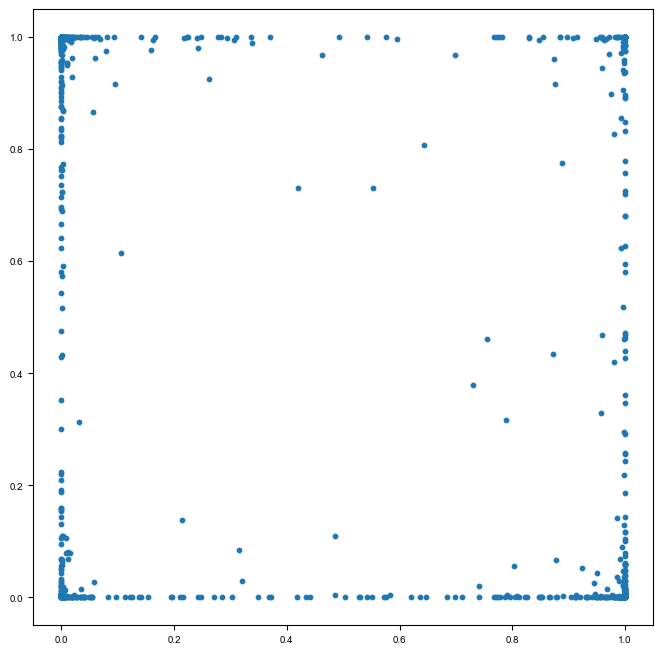

In [12]:
run_no += 1

############## TRAIN (a single instance) ###############
data_params['N_samples'] = len(Vs)

estimates, Hs, filters, net = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params,
                                                          data_params, E=Es, V=Vs,
                                                          use_GPU=run_params['use_GPU'],
                                                          init_rule=init_rule, use_notebook=True)

if hidden_dim > 1:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.scatter(Hs[-1, :, 0], Hs[-1, :, 1], s=10)
    

### Crudely visualize the training

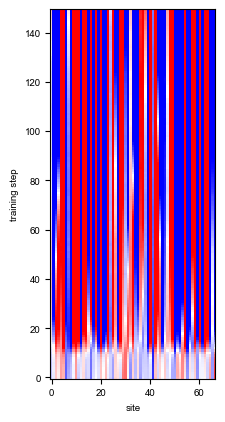

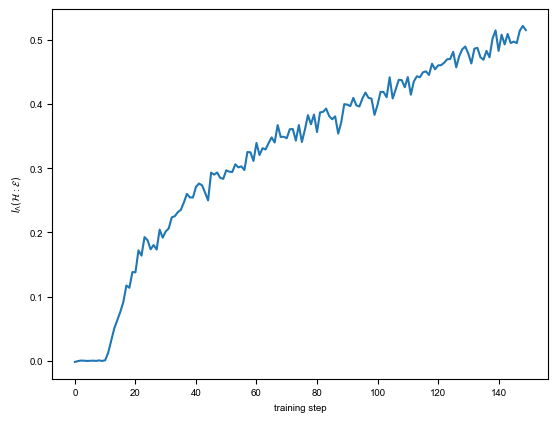

In [13]:
plt.figure()

# plot the filters (flattened to a 1D array) with time dimension going up:
if len(nonlinearCG_layers) == 1:
    heat = np.array([filters[:, i, 0]
                    for i in range(filters.shape[1])]).transpose()
    plt.imshow(heat, cmap='bwr', interpolation='nearest',
               aspect=1, origin="lower", vmin=-0.2, vmax=0.2)
else:
    heat = np.array([filters[i][0][:, 0] for i in range(len(filters))])
    plt.imshow(heat, cmap='bwr', interpolation='nearest',
               aspect=2, origin="lower", vmin=-0.2, vmax=0.2)
plt.xlabel('site')
plt.ylabel('training step')
plt.show()

%matplotlib inline

# Plot the mutual information (MI) as a function of training step:
plt.figure()

#best_estimate_id = np.nonzero(estimates>1e-1)[0][-1]

plt.plot(estimates)
#plt.axvline(best_estimate_id, color='gray', alpha=0.3)
plt.xlabel('training step')
plt.ylabel(r'$I_\Lambda(\mathcal{H}:\mathcal{E})$')
plt.show()


# Analyse the results

## Visualize the trained networks (coarse graining map)


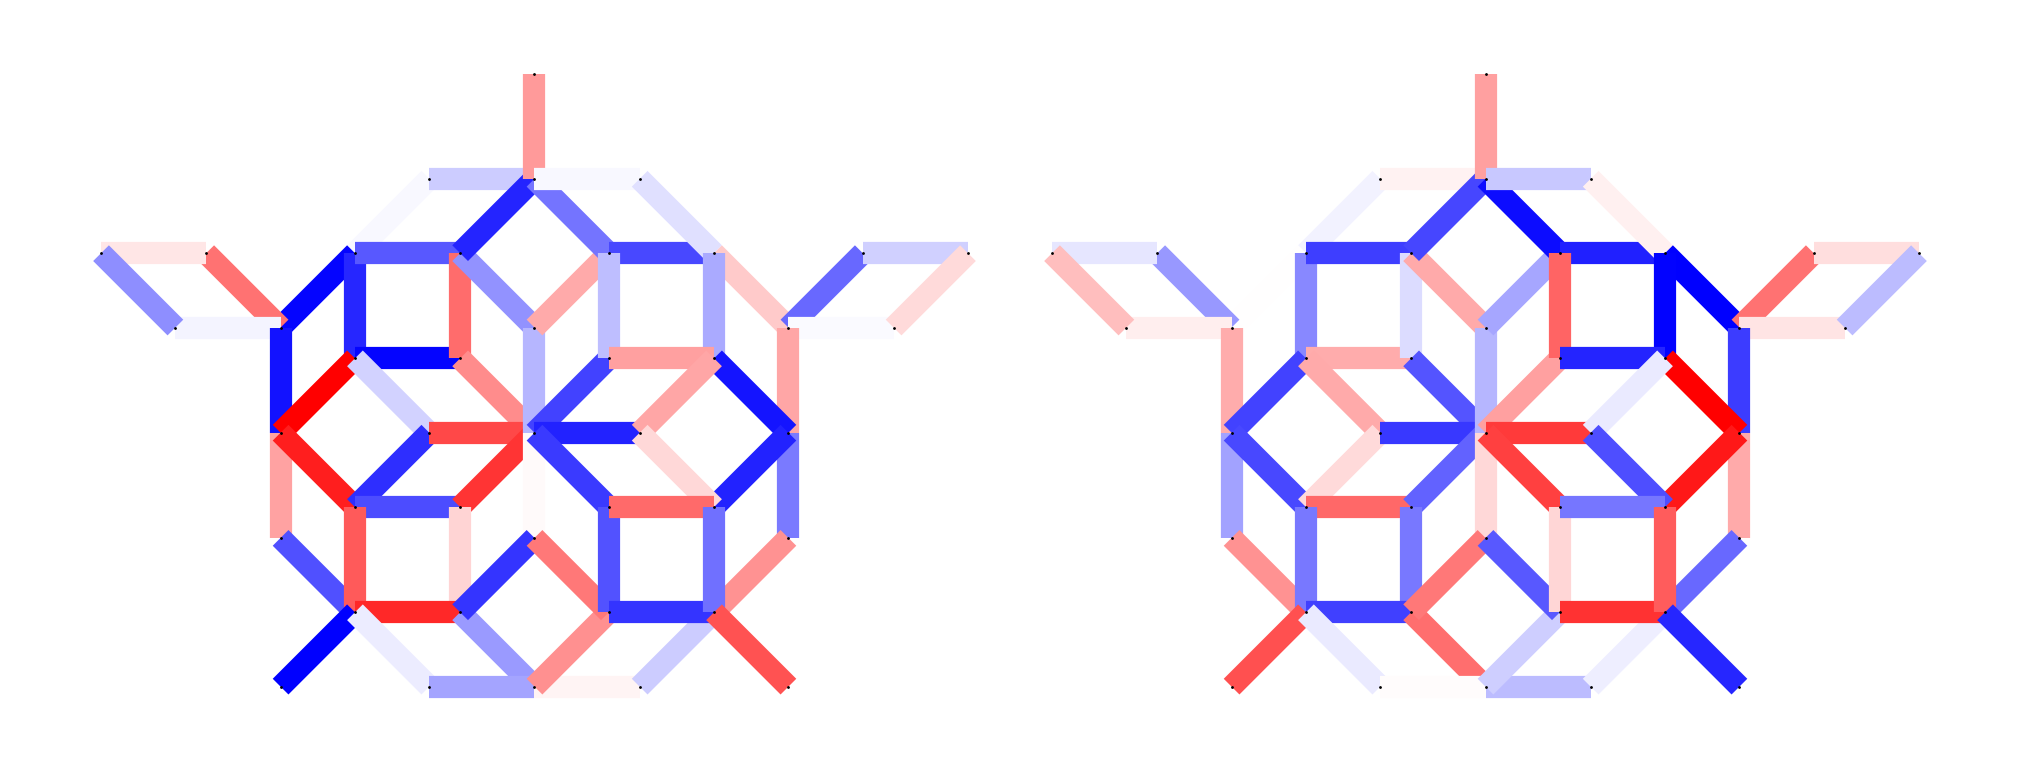

In [14]:
# The nice built-in visualization functions expect this "dictionary of cases" format of inputs.
%matplotlib inline

scale_fac = 2*int(np.ceil(np.cbrt(len(cGV_edges[EV_params['case_no']]))))
if len(nonlinearCG_layers) > 1:
    if nonlinearCG_layers[0] > 20:
        skip = nonlinearCG_layers[0] // 20
        num_cols = 20
    else:
        skip = 1
        num_cols = nonlinearCG_layers[0]

    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1][0][:, ::skip], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=num_cols, figsize=(num_cols*scale_fac, 3*scale_fac), title="hidden", width=16,)
else:
    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=hidden_dim, figsize=(hidden_dim*scale_fac, 3*scale_fac), title="hidden", width=16)


Save a figure for the trained filters.

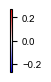

In [22]:
small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1], edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=hidden_dim, figsize=(7*cm, 1.3*cm), title="hidden", width=1.33, node_size=0,
                  savename=scale+'_'+vertex_type+'v_filters.pdf')


a = np.array([[-np.max(filters[-1]), np.max(filters[-1])]])
plt.figure(figsize=(0.1*cm, 2*cm))
img = plt.imshow(a, cmap="bwr")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.1, 0.6, 0.8])
plt.colorbar(orientation="vertical", cax=cax,)
cax.yaxis.set_ticks_position('right')

#plt.savefig("colorbar.pdf", bbox_inches="tight")


### Purify the filters by generating rotated components

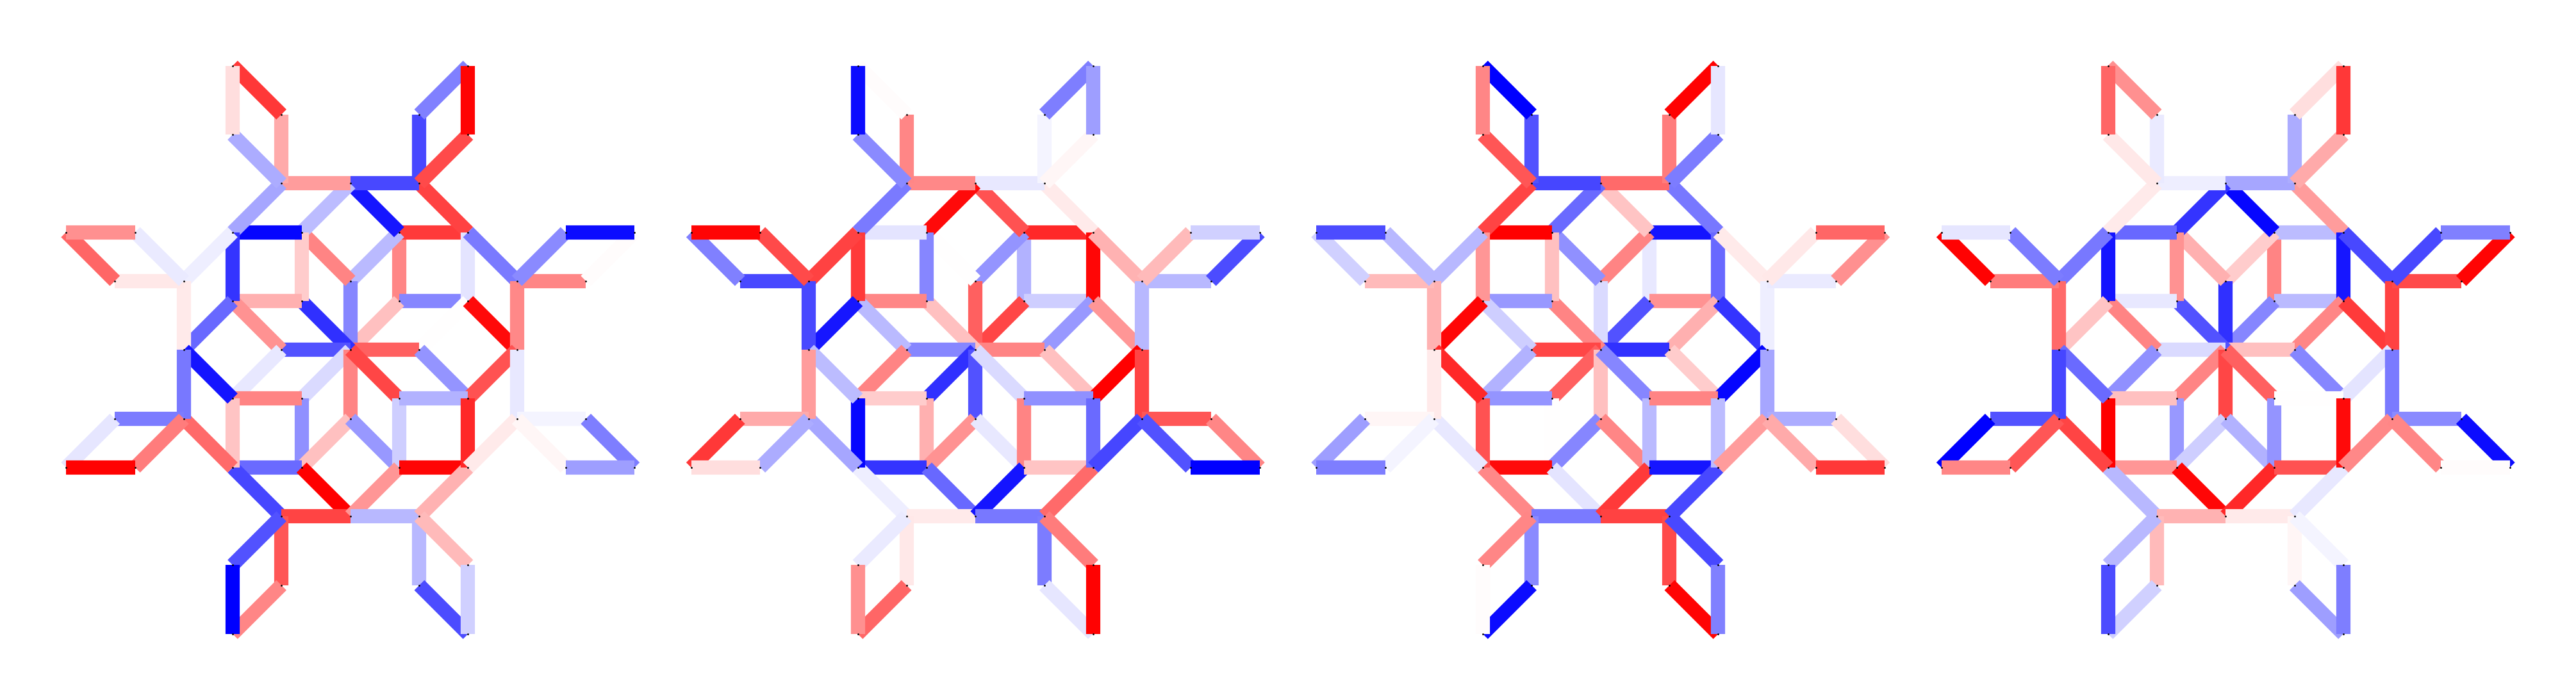

In [45]:
angle = np.pi/2

fid = 2

f = []
for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])


for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], 5*np.pi/4+i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])

purified_filters = np.array(f).transpose()

small_V_visualize(cGV_edges[EV_params['case_no']], purified_filters, edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=4, figsize=(hidden_dim*scale_fac, 3*scale_fac),
                  title="hidden", width=16)


### Distribution of pre-activations

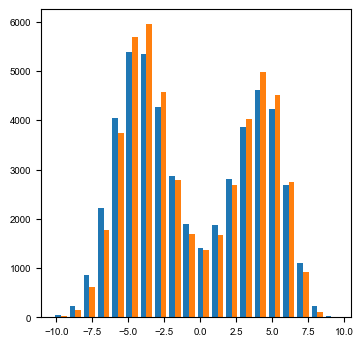

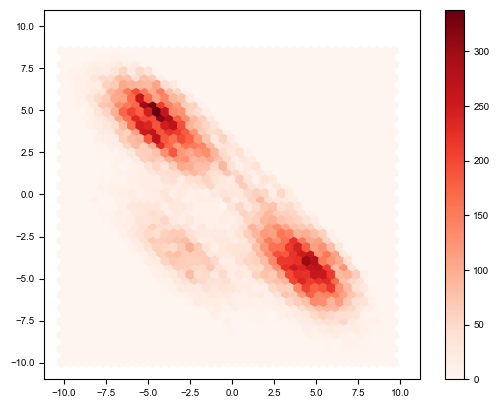

In [15]:
test_prods = dot_prod_V(Vs_dict[case_no][:, :, 0],
                        None, filters[-1])

fig = plt.figure(figsize=(4, 4))
plt.hist(test_prods[:], bins=20)

hexbin_visualize(test_prods[:, 0], test_prods[:, 1], gridsize=40)


## Analysis of the coarse-grained variables

### Distribution of the variables $\mathcal{H}$

First compute the coarse-grained variables $\mathcal{H}$ for each sample using the optimised map and exact discretisation.

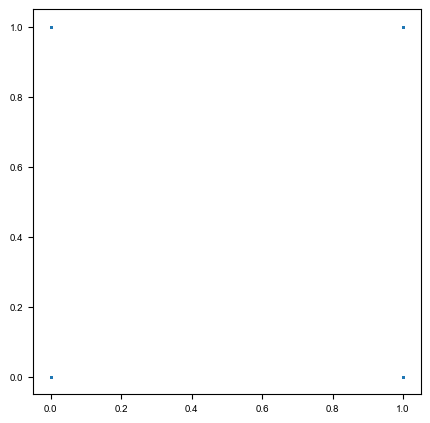

In [20]:
%matplotlib inline

case_no = case_no
vind = V_index

#test_pr = net(Vs_dict[case_no]).numpy()

test_pr = np.heaviside(dot_prod_V(Vs_dict[case_no][:, :, 0],
                                  None, filters[-1]), 0)

fig = plt.figure(figsize=(5, 5))


if hidden_dim > 2:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(test_pr[:, 0], test_pr[:, 1], test_pr[:, 2], s=0.01)
    #ax.set_zlim(-1,1)
    ax.view_init(10, 50)
if hidden_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(test_pr[:, 0], test_pr[:, 1], s=0.01)


### Analyse the statistics of bitstrings

In [21]:
counts, labels, all_labels, hist = embedding_statistics(test_pr, CG_params) #, hidden_dim)


Counter({(0, 1): 21653, (1, 0): 21493, (0, 0): 5920, (1, 1): 934})

01
10
00
11


(-0.5, 3.5)

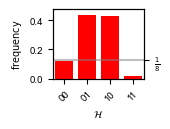

In [22]:
if hidden_dim == 4:
    fig, ax = plt.subplots(1, figsize=(5.5*cm, 2*cm))
elif hidden_dim == 2:
    fig, ax = plt.subplots(1, figsize=(3*cm, 2.3*cm))

if vertex_type == '8':
    colour = 'b'
elif vertex_type == '3':
    colour = 'r'

freqs = {key: counts[key]/len(test_pr) for key in counts}

ymax = 1.1 * max(freqs.values())

ax.axhline(1/8, color='gray', linestyle='-', label=r'$1/8}$', alpha=0.5)
ax.bar(all_labels, freqs.values(), color=colour,)

ax.set_ylabel(r'${\rm frequency}$')
ax.set_xlabel(r'$\mathcal{H}$')
ax.tick_params(axis='x', labelrotation=45)

ax2 = ax.twinx()
ax2.set_yticks([1/8])
ax2.set_yticklabels([r'$\frac{1}{8}$'])
ax2.set_ylim([0, ymax])
ax.set_ylim([0, ymax])
ax.set_xlim([-.5, 2**hidden_dim - .5])

#ax.legend()

#plt.savefig(scale+'_'+vertex_type+'v_dist.pdf', dpi=500, bbox_inches='tight')


In [23]:
# sort the bitstrings around a cycle (if a unique cycle exists)

sorted_labels = [labels[0]]
temp = labels[1:]

while len(temp) > 0:
    
    for check in temp:
        if hamming2(check, sorted_labels[-1]) == 1:
            sorted_labels.append(check)
            temp.remove(check)
            break

sorted_labels


['01', '00', '10', '11']

### Establish the clock variable according to the cycles found

In [88]:
edge_vmax=0.25
edge_vmin=0
width=4

In [89]:
edges_dict = {389: [796, 797, 798, 799, 800, 801, 802, 803],
              196: [797, 793, 7438],
              274: [796, 46282, 792],
              16704: [802, 33336, 39808]}

# TODO: improve this

#### 8-vertex

In [438]:
#sorted_labels = ['1101', '1100', '0100', '0110', '0010', '0011', '1011', '1001']

#freqs = {key: 1/8 for key in sorted_labels}

#print(freqs)

{'1101': 0.125, '1100': 0.125, '0100': 0.125, '0110': 0.125, '0010': 0.125, '0011': 0.125, '1011': 0.125, '1001': 0.125}


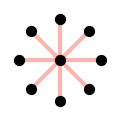

In [439]:
%matplotlib inline

region_of_interest = np.unique(edges_dict[389])

weights = np.ones((len(region_of_interest), 1))

R = small_V_visualize(region_of_interest, weights, edges=edges, nodes=nodes,
                      nodepos=nodepos, node_size=50, figsize=(1, 1), cmap='Pastel1', title="")


weights = []
label_dict = dict()
t = 0
for edge in R.edges:
    label_dict[edge] = sorted_labels[t]
    weights.append(freqs[sorted_labels[t]])
    #print(freqs[sorted_labels[t]])
    t += 1

weights = np.array(weights).reshape((len(region_of_interest), 1))

R = small_V_visualize(region_of_interest, weights, edges=edges, nodes=nodes,
                      nodepos=nodepos, node_size=0, figsize=(3.8*cm, 3.8*cm), cmap='Blues', title="",
                      label_dict=label_dict, edge_vmax=edge_vmax, edge_vmin=edge_vmin, width=width, 
                      savename='8vertex_clock_sigma2.pdf', fontsize=6)


#### 3-vertex

In [840]:
v3_id = 196


In [841]:
freqs_cleaned = freqs.copy()
sorted_labels_cleaned = sorted_labels.copy()

spurious_code = min(freqs_cleaned, key=freqs_cleaned.get)

print(
    f'will now remove {spurious_code} with frequency {freqs_cleaned[spurious_code]}')

del freqs_cleaned[spurious_code]
sorted_labels_cleaned.remove(spurious_code)


will now remove 00 with frequency 0.03854


In [842]:
print(freqs_cleaned)
print(sorted_labels_cleaned)

{'01': 0.42298, '10': 0.42728, '11': 0.1112}
['10', '11', '01']


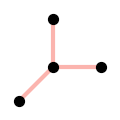

In [966]:
region_of_interest = np.unique(edges_dict[v3_id])

weights = np.ones((len(region_of_interest), 1))

R = small_V_visualize(region_of_interest, weights, edges=edges, nodes=nodes,
                      nodepos=nodepos, node_size=50, figsize=(1, 1), cmap='Pastel1', title="",)

label_dict = dict()
weights = []
t = 0
for edge in R.edges:
    if 389 in edge:
        label_dict[edge] = sorted_labels_cleaned[1]
        weights.append(freqs_cleaned[sorted_labels_cleaned[1]])
    else:
        label_dict[edge] = sorted_labels_cleaned[t]
        weights.append(freqs[sorted_labels_cleaned[t]])
        t += 2

weights = np.array(weights).reshape((len(region_of_interest), 1))

R = small_V_visualize(region_of_interest, weights, edges=edges, nodes=nodes,
                      nodepos=nodepos, node_size=0, figsize=(1.3*cm, 1.3*cm), cmap='Reds', title="",
                      label_dict=label_dict, edge_vmax=edge_vmax, edge_vmin=edge_vmin, width=width+0,
                      savename='3vertex_clock_sigma2.pdf', fontsize=2.5)


### Mutual information estimates with frozen CG maps

#### Estimate $I(\mathcal{V}:\mathcal{E})$ 

In [546]:
n = 1

L_V = Vs.shape[1]
L_E = Es.shape[1]
input_shapes = [(L_V, n), (L_E, n)]

vbmi = VBMI(batch_size, input_shapes=input_shapes, layers=2, embed_dim=32, hidden_dim=64, activation='relu',
            shuffle=100, learning_rate=5e-3, iterations=250, use_dropout=True, dropout_rate=0.3)


In [547]:
mis = vbmi.InfoNCE(Vs, Es)

  0%|          | 0/6250 [00:00<?, ?it/s]

Text(0, 0.5, '$I(\\mathcal{V}:\\mathcal{E})$')

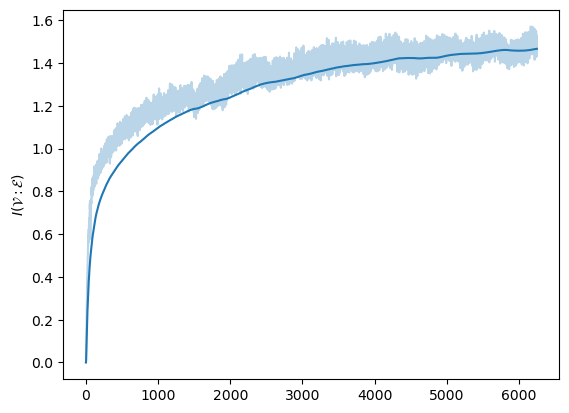

In [551]:
EMA_SPAN = 1000
mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
p1 = plt.plot(mis, alpha=0.3)[0]
plt.plot(mis_smooth, c=p1.get_color())
plt.ylabel(r'$I(\mathcal{V}:\mathcal{E})$')

In [558]:
I_VE = mis_smooth.to_numpy()[-1]

print(f'I(V:E) estimate is {I_VE}.')

I(V:E) estimate is 1.4659861626437258.


#### Estimate $I(\mathcal{H}:\mathcal{E})$ for fixed $\Lambda$

In [238]:
Hs = test_pr 

L_E = Es.shape[1]
input_shapes = [(hidden_dim,), (L_E, 1)]

vbmi = VBMI(batch_size, input_shapes=input_shapes, layers=2, embed_dim=16, hidden_dim=16, activation='relu',
            shuffle=100, learning_rate=5e-3, iterations=60, use_dropout=True, dropout_rate=0.4)


In [239]:
mis = vbmi.InfoNCE(Hs, Es)


  0%|          | 0/1500 [00:00<?, ?it/s]

I(H:E) estimate is 1.4490246525001138.


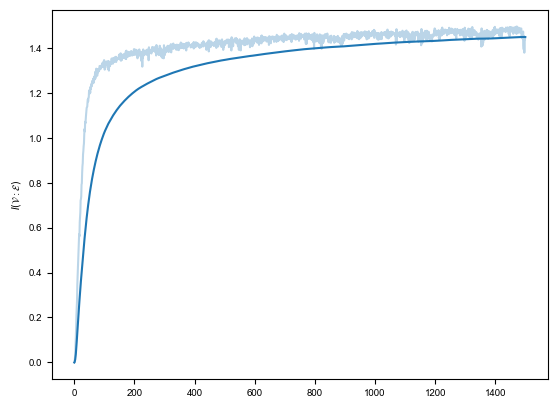

In [240]:
EMA_SPAN = 1000
mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
p1 = plt.plot(mis, alpha=0.3)[0]
plt.plot(mis_smooth, c=p1.get_color())
plt.ylabel(r'$I(\mathcal{V}:\mathcal{E})$')

I_HE = mis_smooth.to_numpy()[-1]

if hidden_dim not in estimates_statistics.keys():
    estimates_statistics[hidden_dim] = []
estimates_statistics[hidden_dim].append(mis_smooth.to_numpy()[-10:])

print(f'I(H:E) estimate is {I_HE}.')


In [288]:
estimates_statistics


{1: [array([0.52419526, 0.52421819, 0.52424678, 0.52423722, 0.52424132,
         0.5242537 , 0.52424395, 0.52426749, 0.52427928, 0.52429961])],
 2: [array([1.08481872, 1.08487228, 1.08494154, 1.08495459, 1.084978  ,
         1.08504265, 1.08509475, 1.08514318, 1.08522987, 1.08526093])],
 3: [array([1.2567231 , 1.25679905, 1.25683311, 1.25686625, 1.25688898,
         1.25692106, 1.25698589, 1.25696764, 1.2570106 , 1.25706471])],
 4: [array([1.45102795, 1.45115756, 1.45120641, 1.45120294, 1.45125652,
         1.45124823, 1.45132428, 1.45135268, 1.45141904, 1.45151285])],
 5: [array([1.37884495, 1.37889276, 1.37887539, 1.37885553, 1.3788452 ,
         1.37876548, 1.37882754, 1.37881877, 1.3788591 , 1.37892069]),
  array([1.44935317, 1.44933332, 1.44938433, 1.449305  , 1.44918852,
         1.44919627, 1.44904951, 1.44904599, 1.44902439, 1.44902465])]}

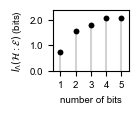

In [290]:
vals = [np.max(est)/np.log(2) for est in estimates_statistics.values()]
devs = [[np.std(est) for est in estimates_statistics.values()], [0 for est in estimates_statistics.values()]]

fig, ax = plt.subplots(1, figsize=(2.5*cm, 2*cm))
ax.stem(estimates_statistics.keys(), vals, markerfmt='k.', linefmt='lightgrey', basefmt=None, bottom=-1)
ax.errorbar(estimates_statistics.keys(), vals, yerr=devs, fmt='.', capsize=0, color='k', ecolor='grey', elinewidth=1)
ax.set_ylim(0,2.4)
ax.set_xlim(0.5,5.5)
ax.set_xlabel('number of bits')
ax.set_ylabel(r'$I_\Lambda(\mathcal{H}:\mathcal{E})$ (bits)')
ax.set_xticks(list(estimates_statistics.keys()))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))

plt.savefig('sigma2_8vertex_numbits.pdf', bbox_inches='tight')
